In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
#import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt
import math
import time
import cv2 as cv
from PIL import Image
from google.colab.patches import cv2_imshow
from tensorflow.keras.applications import VGG16, DenseNet201, ResNet152V2, NASNetLarge

from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#data reading
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/results/results_sample_data_2.csv")
import tensorflow
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

df.Class = df.Class.astype(str)
datagen = ImageDataGenerator()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Veri kümesini bölme işleminden sonra etiketleri one-hot encode et
label_encoder = LabelEncoder()

train_labels = label_encoder.fit_transform(train_df['Class'])
val_labels = label_encoder.transform(val_df['Class'])

# One-hot encoding
train_labels_one_hot = to_categorical(train_labels)
val_labels_one_hot = to_categorical(val_labels)

In [ ]:
target_size=(128,128)


# Create separate data generators for training and validation
train_data_generator = ImageDataGenerator(
    # Your data augmentation and preprocessing parameters here
).flow_from_dataframe(
    dataframe=train_df,
    x_col="Mask_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='categorical',
    shuffle=True,
    target_size=target_size,
)

val_data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=val_df,
    x_col="Mask_path",
    y_col="Class",
    batch_size=64,
    seed=42,
    class_mode='categorical',
    shuffle=False,  # No need to shuffle validation data
    target_size=target_size,
)

Found 4236 validated image filenames belonging to 5 classes.
Found 1059 validated image filenames belonging to 5 classes.


In [ ]:
base_model=DenseNet201(include_top=False, weights='imagenet',input_shape=(128,128,3))
base_model.load_weights(r"/content/drive/MyDrive/Colab Notebooks/Pulmonary Fibrosis/NASNet-large-no-top.h5",by_name=True,skip_mismatch = True)

74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024,activation='relu', kernel_regularizer=l2(l=0.03)))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu', kernel_regularizer=l2(l=0.03)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))


from tensorflow.keras.optimizers import Adam
for layer in base_model.layers[:-10]:
    layer.trainable = False


callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')



model.compile( optimizer=Adam(learning_rate = 0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [7]:
H = model.fit(train_data_generator, validation_data=val_data_generator,
                    steps_per_epoch=4236   //64,
                    epochs = 20,
                    validation_steps= 1059 // 64, callbacks=callback)

Epoch 1/20
66/66 [==============================] - 1184s 18s/step - loss: 42.2832 - accuracy: 0.5499 - val_loss: 36.8666 - val_accuracy: 0.5205
Epoch 2/20
66/66 [==============================] - 550s 8s/step - loss: 32.0193 - accuracy: 0.6395 - val_loss: 27.9291 - val_accuracy: 0.7217
Epoch 3/20
66/66 [==============================] - 597s 9s/step - loss: 24.7611 - accuracy: 0.6860 - val_loss: 21.6874 - val_accuracy: 0.7559
Epoch 4/20
66/66 [==============================] - 593s 9s/step - loss: 19.4694 - accuracy: 0.7212 - val_loss: 17.2981 - val_accuracy: 0.7236
Epoch 5/20
66/66 [==============================] - 588s 9s/step - loss: 15.6333 - accuracy: 0.7347 - val_loss: 13.9857 - val_accuracy: 0.7793
Epoch 6/20
66/66 [==============================] - 589s 9s/step - loss: 12.8110 - accuracy: 0.7519 - val_loss: 11.8741 - val_accuracy: 0.6992
Epoch 7/20
66/66 [==============================] - 591s 9s/step - loss: 10.6921 - accuracy: 0.7749 - val_loss: 9.7423 - val_accuracy: 0.817

17/17 [==============================] - 101s 6s/step


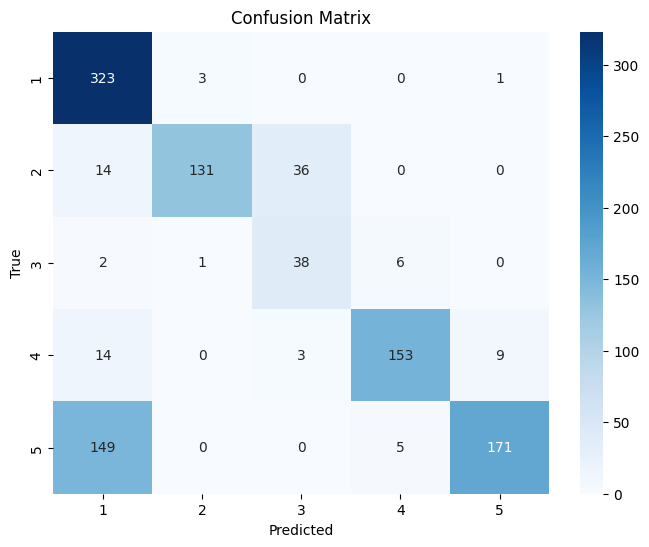

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Modeli kullanarak tahminler yapın
y_pred = model.predict(val_data_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Gerçek etiketleri alın
y_true = val_data_generator.classes

# Confusion matrix oluşturun
cm = confusion_matrix(y_true, y_pred_classes)
class_names=[1,2,3,4,5]
# Matrisi görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Sınıflandırma raporu oluştur
report = classification_report(y_true, y_pred_classes)

# Raporu yazdır
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.99      0.78       327
           1       0.97      0.72      0.83       181
           2       0.49      0.81      0.61        47
           3       0.93      0.85      0.89       179
           4       0.94      0.53      0.68       325

    accuracy                           0.77      1059
   macro avg       0.80      0.78      0.76      1059
weighted avg       0.83      0.77      0.77      1059

